In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab

import types as types

import sys as sys
import os as os
sys.path.append('scripts27/')
sys.path.append('scripts27/gauss_mix')

import pyglet as pgl
import numpy as np

from main import Main
import gmix_model as gmix
import gmix_sample_mixture as smpl
import graph_NPZ as graph_highD

In [2]:
main = Main()
pgl.app.run()

In [3]:
s_x, s_t = gmix.get_xt_from_npz('data/spi_data.npz', True)

rand_x = np.random.random_sample(size=(1000, main.space.expHQ._xDim))
rand_x *= np.sum((main.space.expHQ._xRange*np.array([[[-1,1]]])), axis=2)
rand_x += np.expand_dims(main.space.expHQ._xRange[:,0],0)

_, pv_v, pv_c, pv_t, pv_s, pv_tests = main.space.expHQ.graph_space(s_x)
pv_v = np.expand_dims(pv_v, 1)

_, rand_pv_v, rand_pv_c, _, _, rand_pv_tests = main.space.expHQ.graph_space(rand_x)
rand_pv_v = np.expand_dims(rand_pv_v, 1)

main.space.expModel.build_graph()
#m, v, u = main.space.expModel.get_xmvu()  # this retrieves from a session that isn't updated!
m, v, u = pv_tests[4], pv_tests[5], pv_tests[6]

rand_m, rand_v, rand_u = rand_pv_tests[4], rand_pv_tests[5], rand_pv_tests[6]

x, y = smpl.mixture_expectation(s_x, m, v, u) #set to gmm expectation
_, rand_y = smpl.mixture_expectation(rand_x, rand_m, rand_v, rand_u) #set to gmm expectation
x, y_smpl = smpl.sample_mixture(s_x, m, v, u) #set to gmm sample

In [4]:
c = pv_tests[7]
t = pv_tests[8]
s = pv_tests[9]

print c.shape
print t.shape
print s.shape

c = np.mean(c, 1)
t = np.squeeze(t)
s = np.mean(s, 1)

print c.shape
print t.shape
print s.shape

print (c+t+s).shape

(5000, 1)
(5000, 1)
(5000, 1)
(5000,)
(5000,)
(5000,)
(5000,)


(1000, 4)
(1000, 1)


<IPython.core.display.Javascript object>


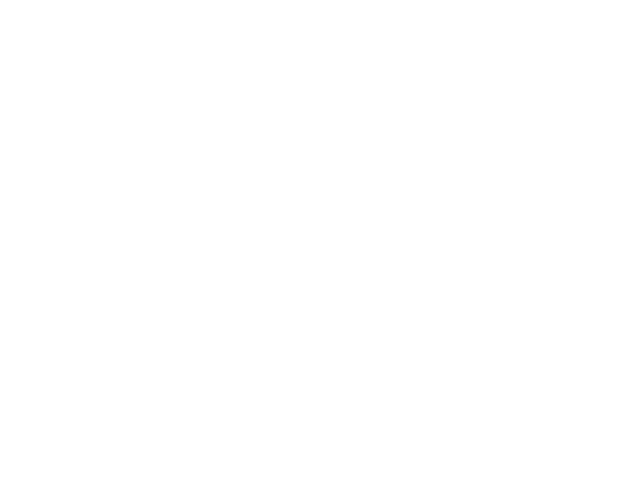

(<matplotlib.figure.Figure at 0x119f6e390>,
  <matplotlib.axes._subplots.Axes3DSubplot at 0x119ee5790>])

In [5]:
xCols = [0,1,-1]
yLow = None#-0.05
yHigh = None#0.05
numPoints = 600

#point value
#fig, _ = graph_highD.graph3x1y(s_x, v, xCols=xCols,
#                      sbpltLoc=221, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, c, xCols=xCols, fig=fig,
#                      sbpltLoc=222, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, t, xCols=xCols, fig=fig,
#                      sbpltLoc=223, numPoints=numPoints)
#graph_highD.graph3x1y(s_x, s, xCols=xCols, fig=fig,
#                      sbpltLoc=224, numPoints=numPoints)

#sensor sample
#graph_highD.graph3x1y(s_x, y_smpl, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)
#sensor expecation

print rand_x.shape
print rand_y.shape

#graph_highD.graph3x1y(s_x, y, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols,
                      yLow=yLow, yHigh=yHigh, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2)

#actual sensor
#graph_highD.graph3x1y(s_x, s_t, xCols=xCols,
#                      yLow=yLow, yHigh=yHigh, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

In [6]:
explorerSeries = np.array(main.space.expHQ._explorerSeries)
explorerGradients = np.array(main.space.expHQ._explorerGrads)
explorerVals = np.array(main.space.expHQ._explorerVals)
explorerBest = np.array(main.space.expHQ._explorerBest)

<IPython.core.display.Javascript object>


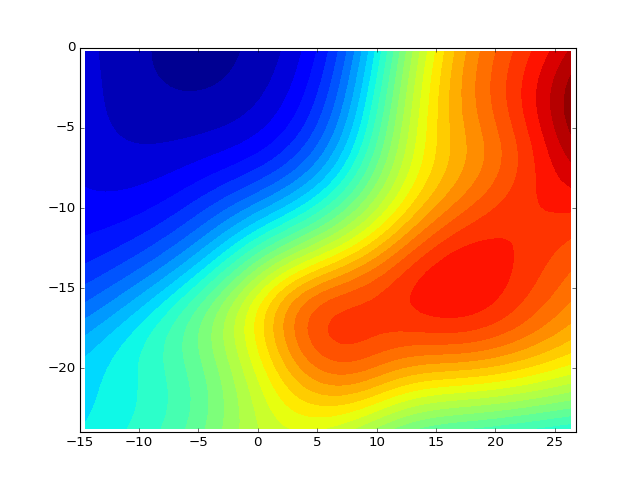

In [12]:
def grid(x, y, z, resX=100, resY=100):
    "Convert 3 column data to matplotlib grid"
    #stolen from http://stackoverflow.com/questions/18764814/make-contour-of-scatter
    xi = np.linspace(min(x), max(x), resX)
    yi = np.linspace(min(y), max(y), resY)
    Z = mlab.griddata(x, y, z, xi, yi, interp='linear')
    X, Y = np.meshgrid(xi, yi)
    return X, Y, Z

#ea is exploration animation
ea_numFrames = 30
ea_mapResolution = 10000 # m
ea_CFindices = np.array([0,-1])  # needs to be 2d for this to work.

ea_fig = plt.figure()

ea_artists = []

ea_EFmask = np.ones(explorerSeries[0,0,:].shape, dtype=bool)  # .shape == (xDim,)
ea_EFmask[ea_CFindices] = 0
ea_full = np.zeros(((ea_mapResolution,) + ea_EFmask.shape), dtype=float)  # .shape == (m, xDim)


for i in range(ea_numFrames):
    
    ea_conRands = np.random.random_sample(size=(ea_mapResolution, ea_CFindices.size))  #.shape == (m, numCF)
    ea_rangeSize = main.space.expHQ._xRange[ea_CFindices]*np.array([[-1,1]])  #.shape == (numCF, 2)
    ea_conRands *= np.expand_dims(np.sum(ea_rangeSize, axis=1), 0)  # (m, numCF) * (1, numCF)
    ea_conRands += np.expand_dims(main.space.expHQ._xRange[ea_CFindices,0], 0)  # (m, numCF) * (1, numCF)
    
    #set the values for all the explorers
    ea_full[:,ea_EFmask] = explorerSeries[i,0,ea_EFmask]  # set environmentals  (m, xDim)[:,numEF] = (numEF,)
    ea_full[:,ea_CFindices] = ea_conRands  # set controls  (m, xDim)[:,numCF] = (m, numCF)
    
    _, ea_pv, ea_pc, ea_pt, ea_ps, _ = main.space.expHQ.graph_space(ea_full)
    
    X, Y, Z = grid(np.copy(ea_full[:,ea_CFindices[0]]), np.copy(ea_full[:,ea_CFindices[1]]), np.squeeze(ea_ps))
    
    ea_frame = plt.contourf(X, Y, Z, 30)
    
    ###Monkey Fix from
    #http://matplotlib.1069221.n5.nabble.com/Matplotlib-1-1-0-animation-vs-contour-plots-td18703.html
    def setvisible(self,vis):
        for c in self.collections: c.set_visible(vis)
    ea_frame.set_visible = types.MethodType(setvisible,ea_frame,None)
    ea_frame.axes = plt.gca()
    ###End monkey fix
    ###Monkey Fix 2
    #adapted from monkey fix 1
    def setanimated(self,anim):
        for c in self.collections: c.set_animated(anim)
    ea_frame.set_animated = types.MethodType(setanimated,ea_frame,None)
    ###
    
    ea_artists.append((ea_frame,))
    
ea_ani = animation.ArtistAnimation(ea_fig, ea_artists, interval=100, repeat_delay=1000, blit=True)
ea_ani.save('data/ea_test.mp4', metadata={'artist':'Andy'})

In [ ]:
sys.path

In [ ]:
fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

print ims
im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=1000,
                                   blit=True)
#im_ani.save('im.mp4', metadata={'artist':'Guido'})

#plt.show()

In [ ]:
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_y, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2)

#pv
fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_v, xCols=xCols, fig=None,
                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

figStuff[1].scatter(
                    xs = explorerBest[:,xCols[0]],
                    ys = explorerBest[:,xCols[1]],
                    zs = explorerBest[:,xCols[2]],
                    marker = '*', s=50)

explorerID = 3
#figStuff[1].plot(
#                    xs = explorerSeries[:,explorerID,xCols[0]],
#                    ys = explorerSeries[:,explorerID,xCols[1]],
#                    zs = explorerSeries[:,explorerID,xCols[2]])

#------
#fig, figStuff = graph_highD.graph3x1y(rand_x, rand_pv_c, xCols=xCols, fig=None,
#                      sbpltLoc=111, numPoints=numPoints*2, alpha=0.3)

In [ ]:
#explorerSeries.shape = (s, e, x)
#explorerVals.shape = (s, e)
print explorerGradients.shape
print explorerSeries.shape
print explorerVals.shape

print explorerSeries[:,explorerID,0].shape
print explorerVals[:,explorerID].shape

plt.figure()
plt.quiver(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1],
           explorerGradients[:,explorerID,0], explorerGradients[:,explorerID,-1],
           explorerVals[:,explorerID]
          )
plt.plot(explorerSeries[:,explorerID,0], explorerSeries[:,explorerID,-1])
#start point
plt.scatter(explorerSeries[0,explorerID,0], explorerSeries[0,explorerID,-1], marker='s', s=50)


#flattened point value graph over the features
plt.scatter(rand_x[:,0], rand_x[:,-1], c=rand_pv_v, alpha=0.1)

In [ ]:
print pv_tests[3]

In [ ]:
print y

In [ ]:
evalStr = [
    'calc_agg_grad_w1',
    'calc_agg_grad_b1',
    'calc_agg_grad_w2',
    'calc_agg_grad_b2',
    'calc_agg_grad_w3',
    'calc_agg_grad_b3',

    'v',
    'm',
    'u',
    
    'w1',
    'w2',
    'w3',
    'b1',
    'b2',
    'b3'
    ]
d = main.space.expModel.get_evals(evalStr)

print d['w1']
print d['b2']

In [ ]:
np.ones((5,3,2)).shape[1:]